In [1]:
!pip install -q transformers pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tabulate import tabulate
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers.pipelines.pt_utils import KeyDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

!wget -O 'processed_comments.parquet' -q https://www.dropbox.com/s/t4hog3o4qf1cu7a/processed_comments%20%281%29.parquet?dl=0
!wget -O 'processed_gt.csv' -q https://www.dropbox.com/s/0n6w06m9g8tyjbl/processed_gt%20%281%29.csv?dl=0
!wget -O 'rubert-tiny2_catast.zip' -q https://www.dropbox.com/s/rmr8xikpfer56d3/checkpoint-1800.zip?dl=0
!unzip rubert-tiny2_catast.zip && rm rubert-tiny2_catast.zip

Archive:  rubert-tiny2_catast.zip
   creating: checkpoint-1800/
 extracting: checkpoint-1800/config.json  
 extracting: checkpoint-1800/pytorch_model.bin  
 extracting: checkpoint-1800/training_args.bin  


In [3]:
df = pd.read_parquet('processed_comments.parquet')

In [4]:
y = df['is_catastrophizing']
X = df['tokens'].values.astype('str')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

---

### TF-IDF + логистическая регрессия

In [6]:
# пайплайн для определения оптимальных параметров TfidfVectorizer с LogReg
pipeline_tfidf_logreg = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=0)),
])

In [7]:
# задание параметров, по которым будет производиться поиск
parameters = [{
    'vect__max_df': (1, 0.95),
    'vect__min_df': (0, 0.05),
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2)),
}]

In [8]:
grid_search_tfidf_logreg = GridSearchCV(pipeline_tfidf_logreg, parameters)

In [9]:
grid_search_tfidf_logreg.fit(X_train, y_train);

In [10]:
grid_search_tfidf_logreg.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.95, min_df=0, ngram_range=(1, 2))),
                ('clf', LogisticRegression(random_state=0))])>

In [11]:
# отсекаются наиболее частые термы, используются только униграммы
vectorizer_tfidf_logreg = TfidfVectorizer(max_df=0.95, min_df=0, ngram_range=(1, 1))

In [12]:
vectorizer_tfidf_logreg.fit(X_train);

In [13]:
X_train_tfidf = vectorizer_tfidf_logreg.transform(X_train)
X_test_tfidf = vectorizer_tfidf_logreg.transform(X_test)

In [14]:
logreg_tfidf = LogisticRegression(random_state=0) # логистическая регрессия с TF-IDF
logreg_tfidf.fit(X_train_tfidf, y_train)
y_pred_prob_tfidf_logreg = logreg_tfidf.predict_proba(X_test_tfidf)[:, 1]
y_pred_tfidf_logreg = logreg_tfidf.predict(X_test_tfidf)
# y_pred_tfidf_logreg = [1 if pred>0.6 else 0 for pred in y_pred_prob_tfidf_logreg]

---

### Дообученный rubert-tiny2

In [16]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')
model = AutoModelForSequenceClassification.from_pretrained('checkpoint-1800')

In [17]:
pipe = pipeline('text-classification', model=model, tokenizer=tokenizer)

pipe_dataloader = torch.utils.data.DataLoader(X_test, batch_size = 16)

preds = []
for i, batch in enumerate(tqdm(pipe_dataloader, position=0, leave=True)):
    outputs = pipe(batch)
    preds.append(outputs)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
100%|██████████| 375/375 [00:49<00:00,  7.58it/s]


In [18]:
# y_pred_rubert = [pred['label'] if (pred['label']==1 and pred['score']>0.6) else 0 for batch in preds for pred in batch]
y_pred_rubert = [pred['label'] for batch in preds for pred in batch]

In [19]:
y_pred_prob_rubert = [pred['score'] if pred['label']==1 else (1 - pred['score']) for batch in preds for pred in batch ]

---

In [20]:
y_pred_prob_tfidf_logreg

array([0.38729692, 0.50103316, 0.5133944 , ..., 0.66160478, 0.58889869,
       0.5296294 ])

### ROC-кривые и матрицы ошибок


In [21]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_shape(type="line", line=dict(dash="dash"), x0=0, x1=1, y0=0, y1=1)

name = "TF-IDF_logreg"
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_tfidf_logreg)
auc_value = round(auc(fpr, tpr), 2)
fig.add_trace(go.Scatter(x=fpr, y=tpr, name=f"{name}: {auc_value}", mode="lines"))

name = "rubert-tiny2"
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rubert)
auc_value = round(auc(fpr, tpr), 2)
fig.add_trace(go.Scatter(x=fpr, y=tpr, name=f"{name}: {auc_value}", mode="lines"))

fig.update_layout(
    width=600,
    height=600,
    template="plotly_white",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    title="AUC-ROC",
    legend=dict(yanchor="bottom", y=0.01, xanchor="right", x=0.99),
)

fig.show()

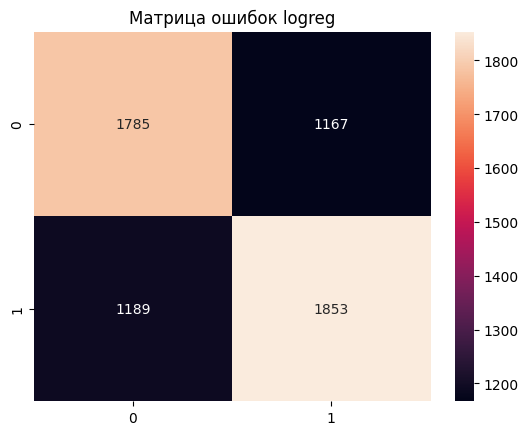

In [22]:
sns.heatmap(confusion_matrix(y_test, y_pred_tfidf_logreg),
            annot=True,
            fmt='g')
plt.title('Матрица ошибок logreg')
plt.show()

In [23]:
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60      2952
           1       0.61      0.61      0.61      3042

    accuracy                           0.61      5994
   macro avg       0.61      0.61      0.61      5994
weighted avg       0.61      0.61      0.61      5994



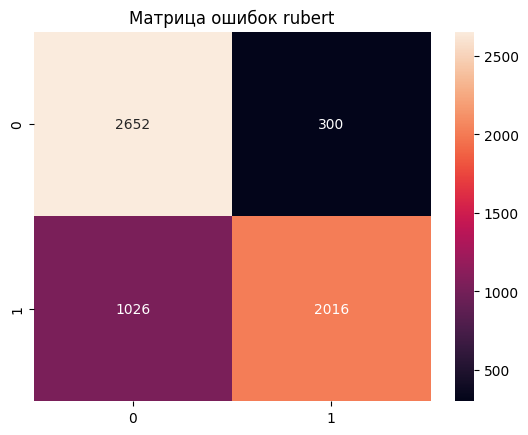

In [24]:
sns.heatmap(confusion_matrix(y_test, y_pred_rubert),
            annot=True,
            fmt='g')
plt.title('Матрица ошибок rubert')
plt.show()

In [25]:
print(classification_report(y_test, y_pred_rubert))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80      2952
           1       0.87      0.66      0.75      3042

    accuracy                           0.78      5994
   macro avg       0.80      0.78      0.78      5994
weighted avg       0.80      0.78      0.78      5994



---

### Проверка на dev сете

In [27]:
gt = pd.read_csv('processed_gt.csv')

In [28]:
gt_X, gt_Y = gt['tokens'].values.astype('str'), gt['is_catastrophizing']

### TF-IDF + logreg

In [29]:
gt_logreg = vectorizer_tfidf_logreg.transform(gt_X)

In [30]:
# y_pred_prob_gt_logreg = logreg_tfidf.predict_proba(gt_logreg)[:, 1]
# y_pred_gt_logreg = [1 if pred>0.6 else 0 for pred in y_pred_prob_gt_logreg]
y_pred_gt_logreg = logreg_tfidf.predict(gt_logreg)

In [31]:
gt['preds_logreg'] = y_pred_gt_logreg

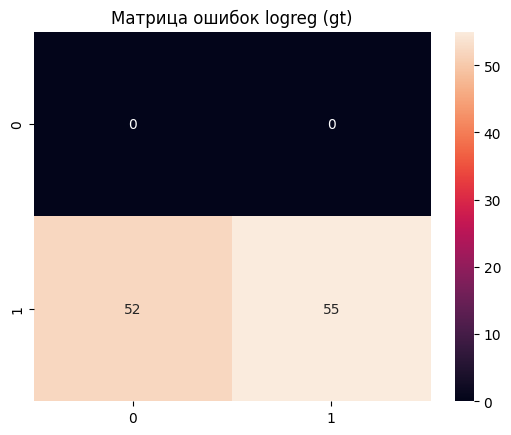

In [32]:
sns.heatmap(confusion_matrix(gt['is_catastrophizing'], gt['preds_logreg']),
            annot=True,
            fmt='g')
plt.title('Матрица ошибок logreg (gt)')
plt.show()

### rubert-tiny2_catast

In [34]:
pipe_dataloader_gt = torch.utils.data.DataLoader(gt_X, batch_size = 16)

preds_gt = []
for i, batch in enumerate(tqdm(pipe_dataloader_gt, position=0, leave=True)):
    outputs = pipe(batch)
    preds_gt.append(outputs)

100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


In [35]:
# y_pred_gt_rubert = [pred['label'] if (pred['label']==1 and pred['score']>0.6) else 0 for batch in preds_gt for pred in batch]
y_pred_gt_rubert = [pred['label'] for batch in preds_gt for pred in batch]

In [36]:
gt['preds_rubert'] = y_pred_gt_rubert

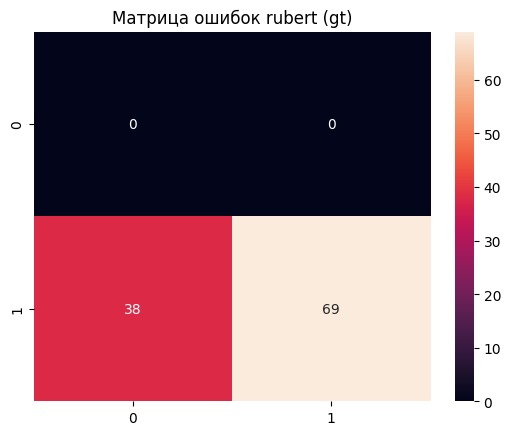

In [37]:
sns.heatmap(confusion_matrix(gt['is_catastrophizing'], gt['preds_rubert']),
            annot=True,
            fmt='g')
plt.title('Матрица ошибок rubert (gt)')
plt.show()

---

### Инференс лучшей модели (rubert-tiny2_catast)

In [77]:
text = ['нам всем конец',
        'ужас, и как теперь жить?',
        'скорее всего, они придут к власти',
        'парадокс в том что те страны бывшего СССР в которых есь нефть и газ живут на много беднее тех котох ископаемых нет',
        'ужасно красивый фильм!'
        ]

labels = ['not_catast', 'catast']
id2label = {idx:label for idx, label in enumerate(labels)}

encoding = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
encoding = {k: val.to(model.device) for k, val in encoding.items()}

outputs = model(**encoding)
logits = outputs.logits

In [78]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs > 0.5)] = 1
for i, p in enumerate(predictions):
    predicted_labels = [id2label[idx] for idx, label in enumerate(p) if label == 1.0]
    print(f'{text[i]}:')
    print('not_catast') if not predicted_labels else print(predicted_labels[0])

нам всем конец:
catast
ужас, и как теперь жить?:
catast
скорее всего, они придут к власти:
not_catast
парадокс в том что те страны бывшего СССР в которых есь нефть и газ живут на много беднее тех котох ископаемых нет:
not_catast
ужасно красивый фильм!:
catast


In [79]:
probs

tensor([[0.0994, 0.8608],
        [0.1475, 0.8217],
        [0.6537, 0.3852],
        [0.5951, 0.4392],
        [0.1638, 0.8064]], grad_fn=<SigmoidBackward0>)

---

### Итоговая таблица

Все метрики даны для положительного класса (catast)

Таблица для тестовых данных

In [80]:
table_test = [['Модель', 'precision', 'recall', 'f1-score'],
              ['LogReg', 0.61, 0.61, 0.61],
              ['rubert-tiny2_catast', 0.87, 0.66, 0.75]]

In [81]:
print(tabulate(table_test, headers='firstrow', tablefmt='grid'))

+---------------------+-------------+----------+------------+
| Модель              |   precision |   recall |   f1-score |
+=====================+=============+==========+============+
| LogReg              |        0.61 |     0.61 |       0.61 |
+---------------------+-------------+----------+------------+
| rubert-tiny2_catast |        0.87 |     0.66 |       0.75 |
+---------------------+-------------+----------+------------+
